In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print('PyTorch version:', torch.__version__, ' Device:', device)

PyTorch version: 2.0.1  Device: cpu


In [2]:
adata = sc.read_h5ad("integrated.h5ad")

In [3]:
adata.X.shape

(108822, 21306)

In [5]:
expression_matrix = adata.X
expression_matrix

<108822x21306 sparse matrix of type '<class 'numpy.float32'>'
	with 95423072 stored elements in Compressed Sparse Row format>

In [6]:
#gene names 
adata.var_names.shape

(21306,)

In [7]:
#Since we are working with a sparse matrix and regular PCA might not work

n_components = 100  
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(expression_matrix)

In [9]:
svd_matrix.shape

(108822, 100)

In [11]:
def map_cond(x):
    if 'cov' in x:
        return 'COVID19'
    else:
        return 'control'

In [12]:
adata.obs['condition'] = adata.obs.Sample.map(map_cond)
adata.obs['condition']

TCCACCAAGAACCCGA-1_15    COVID19
GTGCTGGTCAGACCGC-1_15    COVID19
GTTTACTCATATCGGT-1_15    COVID19
TTGACCCTCTACTTCA-1_15    COVID19
GCACTAAGTTAGGCTT-1_15    COVID19
                          ...   
GTTGCTCGTGACACAG-1_19    COVID19
AGTCATGAGTGGTTCT-1_19    COVID19
AGCGTATCAGTTTGGT-1_19    COVID19
GTTCTATAGTCATACC-1_19    COVID19
CGAGTTATCACAAGGG-1_19    COVID19
Name: condition, Length: 108822, dtype: object

In [14]:
#Enconding the condition of the cell to numbers
def encode(x):
    if 'COVID19' in x:
        return 1
    else:
        return 0

In [15]:
adata.obs['label'] = adata.obs.condition.map(encode)
adata.obs['label']

TCCACCAAGAACCCGA-1_15    1
GTGCTGGTCAGACCGC-1_15    1
GTTTACTCATATCGGT-1_15    1
TTGACCCTCTACTTCA-1_15    1
GCACTAAGTTAGGCTT-1_15    1
                        ..
GTTGCTCGTGACACAG-1_19    1
AGTCATGAGTGGTTCT-1_19    1
AGCGTATCAGTTTGGT-1_19    1
GTTCTATAGTCATACC-1_19    1
CGAGTTATCACAAGGG-1_19    1
Name: label, Length: 108822, dtype: int64

In [20]:
labels = adata.obs['label']
svd_df = pd.DataFrame(svd_matrix)
combined_data = pd.concat([svd_df, labels], axis=1)
svd_df['label'] = labels.values
svd_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,40.291580,-8.542375,-11.340027,-6.175726,3.692961,6.233450,-3.116502,1.452153,12.789645,2.676724,...,1.410856,-0.017639,0.851175,0.541523,1.639984,-0.796506,-0.369771,-0.672564,0.494294,1
1,44.157379,-16.064678,24.996649,0.271868,-0.972442,0.786004,-4.532938,-3.848809,0.721454,-4.343195,...,1.038476,1.475651,0.852008,-0.237944,-0.405981,0.467138,-0.683971,0.534747,-0.095623,1
2,43.823128,-15.955371,-13.605520,-5.171760,13.025872,2.447882,-5.933302,-1.561514,6.325668,0.569982,...,0.545989,-1.072577,0.305195,-1.512244,0.508122,-0.552704,-0.607190,-0.931139,-0.442455,1
3,42.748772,-13.525289,20.337973,1.449124,-2.484318,0.740672,-2.683775,-1.425515,-1.034523,-3.915215,...,0.438786,-0.726325,-0.019437,-1.137509,-0.248739,-0.100827,1.330834,0.026138,-0.737101,1
4,44.995960,-16.343559,21.983391,0.919937,-3.019184,-0.706993,-1.842115,-5.222583,-5.903101,-6.056580,...,0.022384,-0.471095,0.632267,-0.329095,-0.448617,-0.580567,-0.305460,-0.640575,1.094528,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108817,16.565659,-7.530415,10.719836,-0.850523,-1.545491,-0.180691,-1.704596,-0.249556,0.348933,-0.112821,...,2.226433,0.214887,0.833502,-0.562921,0.763854,-2.831335,-0.763439,0.367545,-1.785835,1
108818,17.923738,-3.406230,3.490632,1.309478,3.441758,-1.209301,7.863941,2.699094,0.698423,-2.582576,...,0.345520,0.646009,-0.071903,-0.382962,-1.656354,0.928419,2.261708,0.595607,0.748171,1
108819,20.704765,7.100773,0.082305,-3.760617,0.330376,-2.135886,0.065738,0.674006,-2.221861,1.675932,...,2.387101,-0.706411,-2.805866,-0.668848,0.586256,-0.148084,-0.147903,1.691405,-1.238830,1
108820,17.506933,-7.523550,8.424211,0.277662,-3.479473,-0.864789,-1.871050,-1.385671,-3.429899,-0.925945,...,0.893965,2.230843,1.520644,1.036332,-1.739078,-1.386750,-1.864486,-2.400704,-0.732613,1


In [23]:
data = svd_df.to_numpy()
data.shape

(108822, 101)

In [32]:
trainset, valset, testset = torch.utils.data.random_split(data, [77057, 15883, 15882])
len(trainset), len(valset), len(testset)

(77057, 15883, 15882)

In [35]:
Batch_size = 100

In [36]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=Batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
#IDEAS
#first train an MLP on the SVD output 
#Try using an autoencoder and then training on that latent representation
#Start simple from an MLP and then use GCN maybe

# **MLP Training**

In [93]:
class Covid_MLP(nn.Module):
    def __init__(self):
        super(Covid_MLP, self).__init__()
        
        self.fc1 = nn.Linear(100, 75)
        self.fc2 = nn.Linear(75, 50)
        self.fc3 = nn.Linear(50, 25)
        self.output = nn.Linear(25, 2)
        
        self.BN1 = nn.BatchNorm1d(75)
        self.BN2 = nn.BatchNorm1d(50)
        self.BN3 = nn.BatchNorm1d(25)
        
        self.drop = nn.Dropout(p=0.2)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.BN1(x)
        x = self.drop(x)
        
        x = F.relu(self.fc2(x))
        x = self.BN2(x)
        x = self.drop(x)
        
        x = F.relu(self.fc3(x))
        x = self.BN3(x)
        x = self.drop(x)
        
        x = self.output(x)
        return x

In [94]:
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

model = Covid_MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
#epochs = tqdm(range(num_epochs))

In [65]:
def train_one_epoch():
  model.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_idx, data in enumerate(trainloader):
    inputs, labels = data[:, :-1].to(device).float(), data[:, -1].long().to(device)

    optimizer.zero_grad()

    outputs = model(inputs) 
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct/Batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_idx % 500 == 499: #printing every 500 batch
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy/500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_idx,
                                                                  avg_loss_across_batches,
                                                                  avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

print()


In [95]:
def train_one_epoch():
    model.train(True)
    
    running_loss = 0.0
    running_accuracy = 0.0

    for batch_idx, data in enumerate(trainloader):
        inputs, labels = data[:, :-1].to(device).float(), data[:, -1].long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / Batch_size

    avg_loss = running_loss / len(trainloader)
    avg_accuracy = running_accuracy / len(trainloader) * 100
    return avg_loss, avg_accuracy

In [96]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[:, :-1].to(device).float(), data[:, -1].long().to(device)

        with torch.no_grad():
            outputs = model(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / Batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [67]:
for epoch_idx in range(num_epochs):
  print(f'Epoch: {epoch_idx + 1}\n')

  train_one_epoch()

  validate_one_epoch()

print("Training Done!")

Epoch: 1

Batch 499, Loss: 0.463, Accuracy: 78.8%
Val Loss: 0.176, Val Accuracy: 94.2%
***************************************************

Epoch: 2

Batch 499, Loss: 0.195, Accuracy: 92.6%
Val Loss: 0.121, Val Accuracy: 95.5%
***************************************************

Epoch: 3

Batch 499, Loss: 0.153, Accuracy: 94.1%
Val Loss: 0.108, Val Accuracy: 95.9%
***************************************************

Epoch: 4

Batch 499, Loss: 0.141, Accuracy: 94.7%
Val Loss: 0.102, Val Accuracy: 96.1%
***************************************************

Epoch: 5

Batch 499, Loss: 0.130, Accuracy: 95.0%
Val Loss: 0.095, Val Accuracy: 96.2%
***************************************************

Epoch: 6

Batch 499, Loss: 0.122, Accuracy: 95.4%
Val Loss: 0.091, Val Accuracy: 96.4%
***************************************************

Epoch: 7

Batch 499, Loss: 0.115, Accuracy: 95.6%
Val Loss: 0.086, Val Accuracy: 96.5%
***************************************************

Epoch: 8

Batch 499,

In [97]:
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    loss, accuracy = train_one_epoch()
    train_losses.append(loss)
    train_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}: Average Loss per Epoch = {loss:.4f}, Accuracy = {accuracy:.2f}%")
    validate_one_epoch()

Epoch 1: Average Loss per Epoch = 0.4447, Accuracy = 79.21%
Val Loss: 0.202, Val Accuracy: 93.7%
***************************************************

Epoch 2: Average Loss per Epoch = 0.1917, Accuracy = 93.03%
Val Loss: 0.121, Val Accuracy: 95.5%
***************************************************

Epoch 3: Average Loss per Epoch = 0.1465, Accuracy = 94.45%
Val Loss: 0.107, Val Accuracy: 95.8%
***************************************************

Epoch 4: Average Loss per Epoch = 0.1328, Accuracy = 94.90%
Val Loss: 0.099, Val Accuracy: 96.1%
***************************************************

Epoch 5: Average Loss per Epoch = 0.1240, Accuracy = 95.27%
Val Loss: 0.094, Val Accuracy: 96.2%
***************************************************

Epoch 6: Average Loss per Epoch = 0.1167, Accuracy = 95.56%
Val Loss: 0.088, Val Accuracy: 96.5%
***************************************************

Epoch 7: Average Loss per Epoch = 0.1118, Accuracy = 95.68%
Val Loss: 0.084, Val Accuracy: 96.6%
***

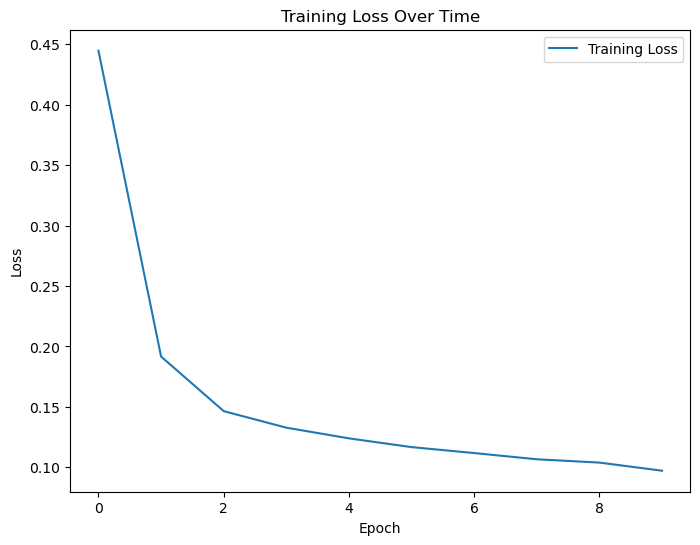

In [98]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

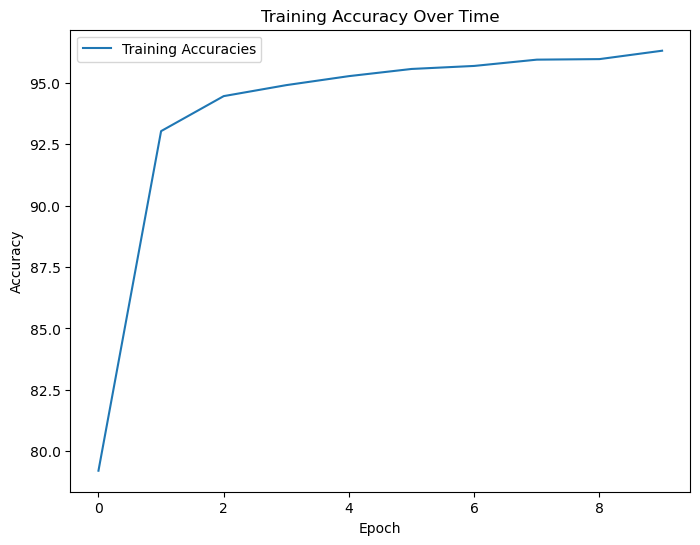

In [99]:
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Time')
plt.legend()
plt.show()

**Testing Phase**

In [68]:
def test_data(testloader):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[:, :-1].to(device).float(), data[:, -1].long().to(device)

        with torch.no_grad():
            outputs = model(inputs) 
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / Batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(testloader)
    avg_acc_across_batches = (running_accuracy / len(testloader)) * 100

    print('Test Loss: {0:.3f}, Test Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [69]:
test_data(testloader)

Test Loss: 0.079, Test Accuracy: 96.8%
***************************************************



In [79]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[:, :-1].to(device).float(), data[:, -1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

In [80]:
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)


In [81]:
class_accuracies

array([0.95771096, 0.97417731])

In [100]:
from sklearn.metrics import roc_curve, auc
import torch

model.eval()  # Set the model to evaluation mode
all_labels = []
all_probs = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data[:, :-1].to(device).float(), data[:, -1].to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())


In [101]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

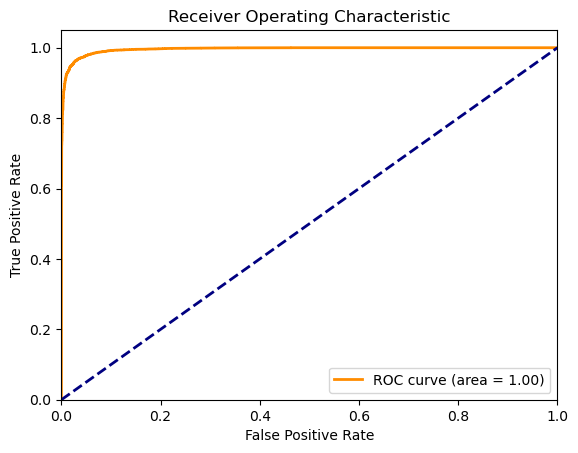

In [102]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#It doesn't make sense to test with the same dataset: so we will find another dataset for testing!!!!!!!!!!
#However we will like to select COVID-19 gene signatures that are predictive of the outcome
#Maybe use an autoencoder after slecting the gene signatures from literature before training 


#Things to do moving forward: Redivide for training and validation and then use external dataset for validation
#Understanding the context and relationships among variables is crucial for effective collinearity reduction. Feature selection using domain knowledge as well as methods like PCA mitigates multicollinearity.



In [12]:
selected_genes = ['CLEC4D', 'UNC5A', 'AURKB']  # replace with your genes of interest
gene_counts = adata[:, selected_genes].X
gene_counts

<108822x2 sparse matrix of type '<class 'numpy.float32'>'
	with 564 stored elements in Compressed Sparse Row format>

In [16]:
"AURKB" in adata.var.index.tolist()

True

In [15]:
len(adata.var.index.tolist()).

21306

pandas.core.indexes.base.Index

# **CNN Training**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(F.max_pool2d(x, 2)))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(F.max_pool2d(x, 2)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.012, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)